32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


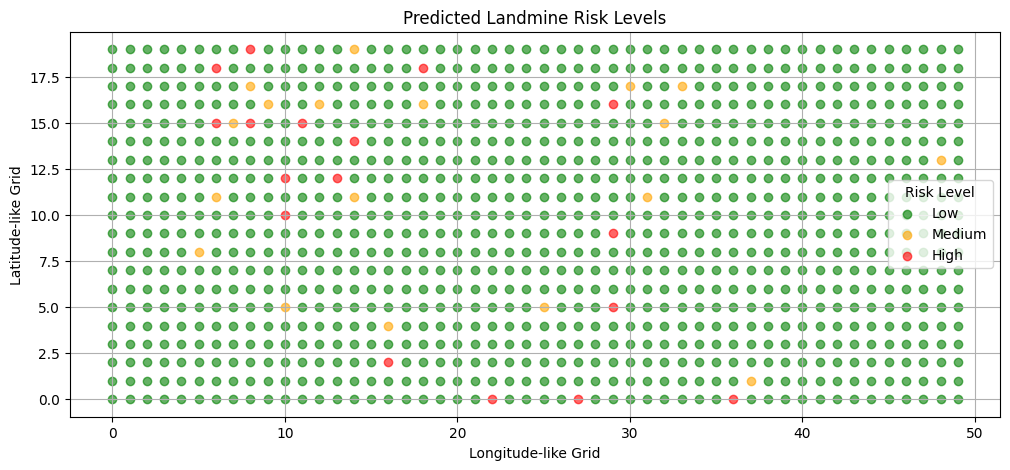

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Simulate a spatial grid (e.g., 50x20 grid of cells)
grid_width, grid_height = 50, 20
n_samples = grid_width * grid_height

np.random.seed(42)
df = pd.DataFrame({
    "x": np.repeat(np.arange(grid_width), grid_height),
    "y": np.tile(np.arange(grid_height), grid_width),
    "altitude": np.random.normal(500, 100, n_samples),
    "distance_to_road": np.random.exponential(1.0, n_samples),
    "proximity_to_past_event": np.random.uniform(0, 1, n_samples),
    "rural_index": np.random.uniform(0, 1, n_samples),
    "deforestation_score": np.random.normal(0.5, 0.1, n_samples),
})

# Ground truth labels (for training purposes only)
df["landmine_risk"] = (
    (df["proximity_to_past_event"] > 0.7) &
    (df["rural_index"] > 0.6) &
    (df["deforestation_score"] > 0.55)
).astype(int)

# 2. Train/test split
X = df[["altitude", "distance_to_road", "proximity_to_past_event", "rural_index", "deforestation_score"]]
y = df["landmine_risk"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. TensorFlow Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# 4. Predict on the full dataset
df["risk_score"] = model.predict(X_scaled).flatten()

# 5. Bucket risk scores into categories
def categorize(score):
    if score < 0.33:
        return "Low"
    elif score < 0.66:
        return "Medium"
    else:
        return "High"

df["risk_level"] = df["risk_score"].apply(categorize)

# 6. Plot the categorized risk map
color_map = {"Low": "green", "Medium": "orange", "High": "red"}
plt.figure(figsize=(12, 5))
for level in color_map:
    subset = df[df["risk_level"] == level]
    plt.scatter(subset["x"], subset["y"], c=color_map[level], label=level, alpha=0.6)

plt.legend(title="Risk Level")
plt.title("Predicted Landmine Risk Levels")
plt.xlabel("Longitude-like Grid")
plt.ylabel("Latitude-like Grid")
plt.grid(True)
plt.show()
